# Medicinal Plant Pytorch Lightning CNN

In [81]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split,SubsetRandomSampler,DataLoader, Dataset, Subset
from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.models import resnet50, ResNet50_Weights,densenet201, DenseNet201_Weights,vgg16, VGG16_Weights,mobilenet_v2, MobileNet_V2_Weights
from torchvision.utils import make_grid
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
import pytorch_lightning as pl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from pytorch_lightning.callbacks import ModelCheckpoint

In [4]:
transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(224),             # resize shortest side to 224 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])

In [5]:
dataset0=datasets.ImageFolder(root="Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset",transform=None)

class_names=dataset0.classes
print(class_names)
print(len(class_names))

['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Astma_weed', 'Badipala', 'Balloon_Vine', 'Bamboo', 'Beans', 'Betel', 'Bhrami', 'Bringaraja', 'Caricature', 'Castor', 'Catharanthus', 'Chakte', 'Chilly', 'Citron lime (herelikai)', 'Coffee', 'Common rue(naagdalli)', 'Coriender', 'Curry', 'Doddpathre', 'Drumstick', 'Ekka', 'Eucalyptus', 'Ganigale', 'Ganike', 'Gasagase', 'Ginger', 'Globe Amarnath', 'Guava', 'Henna', 'Hibiscus', 'Honge', 'Insulin', 'Jackfruit', 'Jasmine', 'Kambajala', 'Kasambruga', 'Kohlrabi', 'Lantana', 'Lemon', 'Lemongrass', 'Malabar_Nut', 'Malabar_Spinach', 'Mango', 'Marigold', 'Mint', 'Neem', 'Nelavembu', 'Nerale', 'Nooni', 'Onion', 'Padri', 'Palak(Spinach)', 'Papaya', 'Parijatha', 'Pea', 'Pepper', 'Pomoegranate', 'Pumpkin', 'Raddish', 'Rose', 'Sampige', 'Sapota', 'Seethaashoka', 'Seethapala', 'Spinach1', 'Tamarind', 'Taro', 'Tecoma', 'Thumbe', 'Tomato', 'Tulsi', 'Turmeric', 'ashoka', 'camphor', 'kamakasturi', 'kepala']
80


In [6]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = "Indian Medicinal Leaves Image Datasets\Medicinal Leaf dataset"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = torch.utils.data.random_split(dataset, [n_train, n_test])

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size,num_workers=4, shuffle=True,persistent_workers=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size,num_workers=4, shuffle=False,persistent_workers=True)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset



In [7]:
class ConvolutionalNetwork(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 80)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

    datamodule = DataModule()
    datamodule.setup()
    train_loader = datamodule.train_dataloader()
    for imgs,labels in train_loader:
        break
    print(labels)

In [8]:
class ConvolutionalNetwork1(LightningModule):
    
    def __init__(self):
        super(ConvolutionalNetwork1, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 20)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [17]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model = ConvolutionalNetwork.load_from_checkpoint("model2.pth")
    checkpoint_callback = ModelCheckpoint(
        monitor='train_loss',
        mode='min',
        filename='best_model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        save_last=True
    )
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        log_every_n_steps=5,
        max_epochs=32,
        callbacks=[checkpoint_callback]
    )
    #trainer.fit(model, datamodule)
    best_model_path = checkpoint_callback.best_model_path
    #model = ConvolutionalNetwork.load_from_checkpoint(best_model_path)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(model,dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.08188405632972717
        test_loss            7.765596866607666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


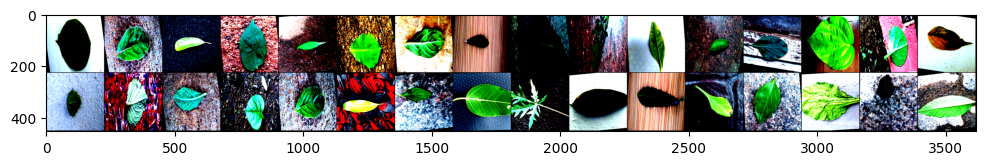

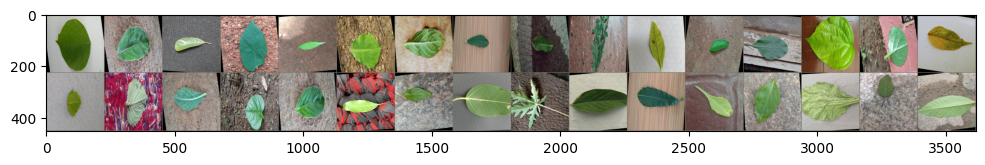

In [15]:
for images, labels in datamodule.train_dataloader():
    break
im=make_grid(images,nrow=16)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

inv_normalize=transforms.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                                   std=[1/0.229,1/0.224,1/0.225])
im=inv_normalize(im)

plt.figure(figsize=(12,12))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))
plt.show()

In [80]:
device = torch.device("cpu")

model.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

print(classification_report(y_true,y_pred,target_names=class_names,digits=4))

                         precision    recall  f1-score   support

               Aloevera     1.0000    0.5000    0.6667         2
                   Amla     0.0000    0.0000    0.0000         2
           Amruthaballi     0.5000    0.5000    0.5000         2
                  Arali     1.0000    0.5000    0.6667         2
                 Bhrami     0.0000    0.0000    0.0000         2
             Bringaraja     1.0000    1.0000    1.0000         2
                 Castor     1.0000    1.0000    1.0000         2
Citron lime (herelikai)     0.0000    0.0000    0.0000         2
 Common rue (naagdalli)     1.0000    1.0000    1.0000         2
             Eucalyptus     0.6667    1.0000    0.8000         2
               Gasagase     0.3333    0.5000    0.4000         2
                  Henna     0.6667    1.0000    0.8000         2
              Kambajala     1.0000    0.5000    0.6667         2
                  Lemon     0.5000    0.5000    0.5000         2
                   Mint 

c:\Users\navan\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\navan\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\navan\envs\ml\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
trainer.save_checkpoint("model3.pth")

In [29]:
dataset1=datasets.ImageFolder(root="herbs",transform=None)

class_names=dataset1.classes
print(class_names)
print(len(class_names))

['Aloevera', 'Amla', 'Amruthaballi', 'Arali', 'Bhrami', 'Bringaraja', 'Castor', 'Citron lime (herelikai)', 'Common rue (naagdalli)', 'Eucalyptus', 'Gasagase', 'Henna', 'Kambajala', 'Lemon', 'Mint', 'Neem', 'Nelavembu', 'Tulsi', 'Turmeric', 'kamakasturi']
20


In [43]:
class DataModule(pl.LightningDataModule):
    
    def __init__(self, transform=transform, batch_size=32):
        super().__init__()
        self.root_dir = "herbs"
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(root=self.root_dir, transform=self.transform)
        n_data = len(dataset)
        n_train = int(0.8 * n_data)
        n_test = n_data - n_train

        train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42,stratify=dataset.targets)

        self.train_dataset = DataLoader(train_dataset, batch_size=self.batch_size,num_workers=4, shuffle=True,persistent_workers=True)
        self.test_dataset = DataLoader(test_dataset, batch_size=self.batch_size,num_workers=4, shuffle=False,persistent_workers=True)

    def train_dataloader(self):
        return self.train_dataset

    def test_dataloader(self):
        return self.test_dataset


In [42]:
if __name__ == '__main__':
    datamodule = DataModule()
    datamodule.setup()
    model1 = ConvolutionalNetwork.load_from_checkpoint("model3.pth")
    model1.fc4 = nn.Linear(20, 20)
    for param in model1.parameters():
        param.requires_grad = False
    model1.fc4.weight.requires_grad = True
    model1.fc4.bias.requires_grad = True
    checkpoint_callback = ModelCheckpoint(
        monitor='train_loss',
        mode='min',
        filename='best_model-{epoch:02d}-{val_loss:.2f}',
        save_top_k=1,
        save_last=True
    )
    trainer = pl.Trainer(
        accelerator='gpu',
        devices=1,
        log_every_n_steps=5,
        max_epochs=300,
        callbacks=[checkpoint_callback]
    )
    trainer.fit(model1, datamodule)
    best_model_path = checkpoint_callback.best_model_path
    model1 = ConvolutionalNetwork1.load_from_checkpoint(best_model_path)
    print(best_model_path)
    datamodule.setup(stage='test')
    test_loader = datamodule.test_dataloader()
    trainer.test(model1,dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\navan\envs\ml\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type   | Params
---------------------------------
0 | conv1 | Conv2d | 168   
1 | conv2 | Conv2d | 880   
2 | fc1   | Linear | 5.6 M 
3 | fc2   | Linear | 10.2 K
4 | fc3   | Linear | 1.7 K 
5 | fc4   | Linear | 420   
---------------------------------
420       Trainable params
5.6 M     Non-trainable params
5.6 M     Total params
22.449    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


c:\Users\navan\Desktop\vit materials\Winter 2023-2024\AI\Research Paper\Raw-Food-Ingredients-Classifier\LEAF\lightning_logs\version_10\checkpoints\best_model-epoch=271-val_loss=0.00.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.699999988079071
        test_loss           0.9229009747505188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [32]:
metrics = pd.read_csv("lightning_logs/version_7/metrics.csv")
train = metrics.iloc[:-1]
test = metrics.iloc[-1]
print(test)

epoch          20.000000
step          100.000000
test_acc        0.850000
test_loss       0.409178
train_acc            NaN
train_loss           NaN
Name: 20, dtype: float64


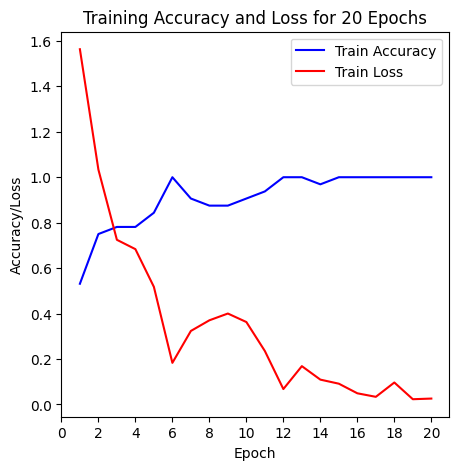

In [33]:
plt.figure(figsize=(5, 5))
epoch = len(train)
plt.plot(train["epoch"] + 1, train["train_acc"], label="Train Accuracy", color="blue")
plt.plot(train["epoch"] + 1, train["train_loss"], label="Train Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.title(f"Training Accuracy and Loss for {epoch} Epochs")
plt.legend()
plt.xticks(np.linspace(0, epoch, num=11, dtype=int))
plt.show()

In [34]:
metrics = pd.read_csv("lightning_logs/version_3/metrics.csv")
train = metrics.iloc[:-1]
test = metrics.iloc[-1]
print(test)

epoch          32.000000
step          160.000000
test_acc        0.875000
test_loss       0.548367
train_acc            NaN
train_loss           NaN
Name: 32, dtype: float64


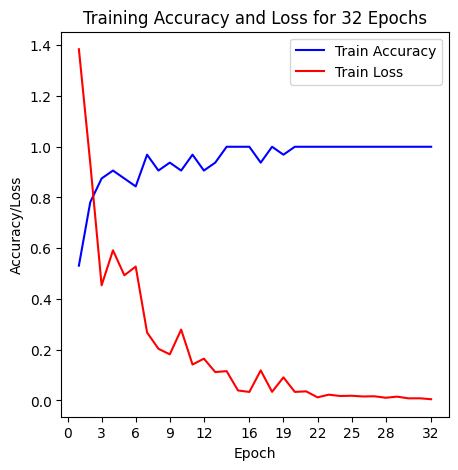

In [35]:
plt.figure(figsize=(5, 5))
epoch = len(train)
plt.plot(train["epoch"] + 1, train["train_acc"], label="Train Accuracy", color="blue")
plt.plot(train["epoch"] + 1, train["train_loss"], label="Train Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.title(f"Training Accuracy and Loss for {epoch} Epochs")
plt.legend()
plt.xticks(np.linspace(0, epoch, num=11, dtype=int))
plt.show()

In [36]:
metrics = pd.read_csv("lightning_logs/version_5/metrics.csv")
train = metrics.iloc[:-1]
test = metrics.iloc[-1]
print(test)

epoch          50.000000
step          250.000000
test_acc        0.950000
test_loss       0.313199
train_acc            NaN
train_loss           NaN
Name: 50, dtype: float64


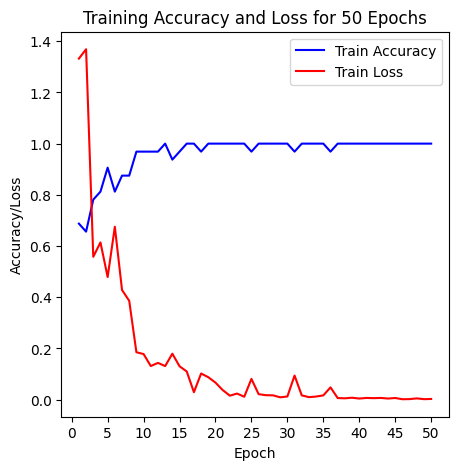

In [37]:
plt.figure(figsize=(5, 5))
epoch = len(train)
plt.plot(train["epoch"] + 1, train["train_acc"], label="Train Accuracy", color="blue")
plt.plot(train["epoch"] + 1, train["train_loss"], label="Train Loss", color="red")
plt.xlabel("Epoch")
plt.ylabel("Accuracy/Loss")
plt.title(f"Training Accuracy and Loss for {epoch} Epochs")
plt.legend()
plt.xticks(np.linspace(0, epoch, num=11, dtype=int))
plt.show()

In [38]:
data = {
    "Epochs": [20, 32, 50],
    "Learning Rate": [0.001, 0.001, 0.001],
    "Batch Size": [32, 32, 32],
    "Test Accuracy": [85, 87.5, 95]
}

df = pd.DataFrame(data)
df

,Epochs,Learning Rate,Batch Size,Test Accuracy
0,20,0.001,32,85.0
1,32,0.001,32,87.5
2,50,0.001,32,95.0


In [79]:
""" # get the confusion matrix with numbers only
device = "cpu"
#model1 = ConvolutionalNetwork1.load_from_checkpoint("lightning_logs/version_13/checkpoints/best_model-epoch=252-val_loss=0.00.ckpt")
model1.eval()
y_true=[]
y_pred=[]
with torch.no_grad():
    for test_data in datamodule.test_dataloader():
        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
        pred = model1(test_images).argmax(dim=1)
        for i in range(len(pred)):
            y_true.append(test_labels[i].item())
            y_pred.append(pred[i].item())

cm = np.zeros((20, 20), dtype=int)
for i in range(len(y_true)):
    cm[y_true[i], y_pred[i]] += 1

plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show() """

' # get the confusion matrix with numbers only\ndevice = "cpu"\n#model1 = ConvolutionalNetwork1.load_from_checkpoint("lightning_logs/version_13/checkpoints/best_model-epoch=252-val_loss=0.00.ckpt")\nmodel1.eval()\ny_true=[]\ny_pred=[]\nwith torch.no_grad():\n    for test_data in datamodule.test_dataloader():\n        test_images, test_labels = test_data[0].to(device), test_data[1].to(device)\n        pred = model1(test_images).argmax(dim=1)\n        for i in range(len(pred)):\n            y_true.append(test_labels[i].item())\n            y_pred.append(pred[i].item())\n\ncm = np.zeros((20, 20), dtype=int)\nfor i in range(len(y_true)):\n    cm[y_true[i], y_pred[i]] += 1\n\nplt.figure(figsize=(10, 10))\nplt.imshow(cm, cmap="Blues")\nplt.colorbar()\nplt.title("Confusion Matrix")\nplt.xlabel("Predicted")\nplt.ylabel("True")\nplt.show() '

In [50]:
class ResNetClassifier(LightningModule):
    
    def __init__(self):
        super(ResNetClassifier, self).__init__()
        self.resnet = models.resnet50(ResNet50_Weights)
        self.resnet.fc = nn.Linear(2048, 20)
        

    def forward(self, X):
        return self.resnet(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [53]:
model = ResNetClassifier()
for param in model.parameters():
    param.requires_grad = False
model.resnet.fc.weight.requires_grad = True
model.resnet.fc.bias.requires_grad = True
model = model.to("cuda")

datamodule = DataModule()
datamodule.setup()
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    filename='best_model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    save_last=True
)
trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    log_every_n_steps=5,
    max_epochs=20,
    callbacks=[checkpoint_callback]
)
trainer.fit(model, datamodule)
best_model_path = checkpoint_callback.best_model_path
model = ConvolutionalNetwork1.load_from_checkpoint(best_model_path)
print(best_model_path)
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(model,dataloaders=test_loader)

c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\navan\envs\ml\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - C

Training: |          | 0/? [00:00<?, ?it/s]

Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\navan\AppData\Local\Programs\Python\Python39\lib\multiprocessing\queues.py", line 241, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "C:\Users\navan\AppData\Local\Programs\Python\Python39\lib\multiprocessing\queues.py", line 241, in _feed
    close()
  File "C:\Users\navan\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 182, in close
    close()
  File "C:\Users\navan\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 182, in close
    self._close()
  File "C:\Users\navan\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 282, in _close
    self._close()
  File "C:\Users\navan\AppData\Local\Programs\Python\Python39\lib\multiprocessing\connection.py", line 282, in _close
    _CloseHandle(self._handle)
OSError: [WinError 6] The handle is invalid

During handling of t

c:\Users\navan\Desktop\vit materials\Winter 2023-2024\AI\Research Paper\Raw-Food-Ingredients-Classifier\LEAF\lightning_logs\version_12\checkpoints\best_model-epoch=16-val_loss=0.00.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7250000238418579
        test_loss           1.2785224914550781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2785224914550781, 'test_acc': 0.7250000238418579}]

In [57]:
class DenseNetClassifier(LightningModule):
    
    def __init__(self):
        super(DenseNetClassifier, self).__init__()
        self.densenet = models.densenet201(DenseNet201_Weights)
        self.densenet.classifier = nn.Linear(1920, 20)
        

    def forward(self, X):
        return self.densenet(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)

In [60]:
model = DenseNetClassifier()
for param in model.parameters():
    param.requires_grad = False
model.densenet.classifier.weight.requires_grad = True
model.densenet.classifier.bias.requires_grad = True

model = model.to("cuda")

datamodule = DataModule()
datamodule.setup()
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    filename='best_model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    save_last=True
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    log_every_n_steps=5,
    max_epochs=20,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, datamodule)
best_model_path = checkpoint_callback.best_model_path
model = DenseNetClassifier.load_from_checkpoint(best_model_path)
print(best_model_path)
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(model,dataloaders=test_loader)

c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\navan\envs\ml\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK:

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\navan\Desktop\vit materials\Winter 2023-2024\AI\Research Paper\Raw-Food-Ingredients-Classifier\LEAF\lightning_logs\version_13\checkpoints\best_model-epoch=19-val_loss=0.00.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.800000011920929
        test_loss           1.2365792989730835
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.2365792989730835, 'test_acc': 0.800000011920929}]

In [63]:
class VGG16Classifier(LightningModule):
    
    def __init__(self):
        super(VGG16Classifier, self).__init__()
        self.vgg16 = models.vgg16(VGG16_Weights)
        self.vgg16.classifier[6] = nn.Linear(4096, 20)
        

    def forward(self, X):
        return self.vgg16(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)


In [64]:
model = VGG16Classifier()
for param in model.parameters():
    param.requires_grad = False

model.vgg16.classifier[6].weight.requires_grad = True
model.vgg16.classifier[6].bias.requires_grad = True

model = model.to("cuda")

datamodule = DataModule()
datamodule.setup()
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    filename='best_model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    save_last=True
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    log_every_n_steps=5,
    max_epochs=20,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, datamodule)
best_model_path = checkpoint_callback.best_model_path
model = VGG16Classifier.load_from_checkpoint(best_model_path)
print(best_model_path)
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(model,dataloaders=test_loader)

c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\navan/.cache\torch\hub\checkpoints\vgg16-397923af.pth
100%|██████████| 528M/528M [00:43<00:00, 12.8MB/s] 
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\navan

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\navan\Desktop\vit materials\Winter 2023-2024\AI\Research Paper\Raw-Food-Ingredients-Classifier\LEAF\lightning_logs\version_14\checkpoints\best_model-epoch=18-val_loss=0.00.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6000000238418579
        test_loss           1.4618988037109375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.4618988037109375, 'test_acc': 0.6000000238418579}]

In [72]:
class MobileNetClassifier(LightningModule):
    
    def __init__(self):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(MobileNet_V2_Weights)
        self.mobilenet.classifier[1] = nn.Linear(1280, 20)
        

    def forward(self, X):
        return self.mobilenet(X)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("val_loss", loss)
        self.log("val_acc", acc)

    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        y_hat = self(X)
        loss = F.cross_entropy(y_hat, y)
        pred = y_hat.argmax(dim=1, keepdim=True)
        acc = pred.eq(y.view_as(pred)).sum().item() / y.shape[0]
        self.log("test_loss", loss)
        self.log("test_acc", acc)


In [75]:
model = MobileNetClassifier()
for param in model.parameters():
    param.requires_grad = False

model.mobilenet.classifier[1].weight.requires_grad = True
model.mobilenet.classifier[1].bias.requires_grad = True

model = model.to("cuda")

datamodule = DataModule()
datamodule.setup()
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    filename='best_model-{epoch:02d}-{val_loss:.2f}',
    save_top_k=1,
    save_last=True
)

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    log_every_n_steps=5,
    max_epochs=20,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, datamodule)
best_model_path = checkpoint_callback.best_model_path
model = MobileNetClassifier.load_from_checkpoint(best_model_path)
print(best_model_path)
datamodule.setup(stage='test')
test_loader = datamodule.test_dataloader()
trainer.test(model,dataloaders=test_loader)

c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\navan\envs\ml\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RAN

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\navan\envs\ml\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\navan\Desktop\vit materials\Winter 2023-2024\AI\Research Paper\Raw-Food-Ingredients-Classifier\LEAF\lightning_logs\version_16\checkpoints\best_model-epoch=18-val_loss=0.00.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.699999988079071
        test_loss           1.3214280605316162
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.3214280605316162, 'test_acc': 0.699999988079071}]

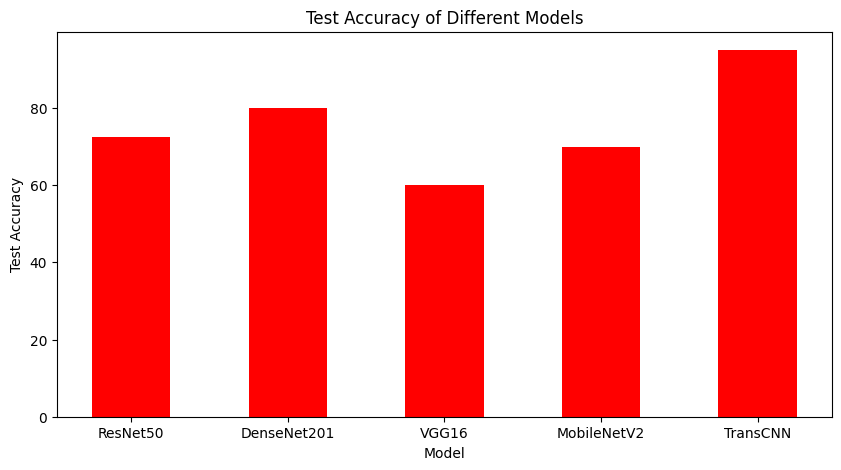

,Model,Test Accuracy,Trainable Parameters,Non Trainable Parameters,Test_loss
0,ResNet50,72.5,41000,23500000,1.28
1,DenseNet201,80.0,38400,18100000,1.24
2,VGG16,60.0,81900,134000000,1.46
3,MobileNetV2,70.0,25600,2200000,1.32
4,TransCNN,95.0,420,5600000,0.31


In [85]:
data = {
    "Model": ["ResNet50", "DenseNet201", "VGG16", "MobileNetV2","TransCNN"],
    "Test Accuracy": [72.5, 80, 60, 70, 95],
    "Trainable Parameters": [41000, 38400, 81900, 25600, 420],
    "Non Trainable Parameters": [23500000, 18100000, 134000000,2200000 , 5600000],
    "Test_loss": [1.28, 1.24, 1.46, 1.32, 0.31]
}


df = pd.DataFrame(data)
plt.figure(figsize=(10, 5))
plt.bar(df["Model"], df["Test Accuracy"], color="red",width=0.5)
plt.xlabel("Model")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy of Different Models")
plt.show()
df

